In [1]:
### 1.1. Install Required Libraries
!pip install ultralytics matplotlib pandas -q

import os
import pandas as pd
import yaml
from ultralytics import YOLO
from ultralytics.utils.checks import check_yaml
import matplotlib.pyplot as plt

print("Setup complete. Libraries installed and imported.")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Setup complete. Libraries installed and imported.


In [3]:
import os
import yaml
from ultralytics.utils.checks import check_yaml

### 2.1. Define Configuration Path
DATA_YAML_PATH = os.path.join('data', 'data.yaml')

### 2.2. Check data.yaml integrity
print(f"--- Checking {DATA_YAML_PATH} integrity ---")
try:
    data_info = check_yaml(DATA_YAML_PATH)
    print("✅ data.yaml structure is valid.")

    # Load the YAML content for inspection
    with open(DATA_YAML_PATH, 'r') as f:
        config = yaml.safe_load(f)

    print("\n--- data.yaml Content ---")
    print(yaml.dump(config, indent=2))

    # Basic verification of file paths
    train_path = config.get('train')
    val_path = config.get('val')
    names = config.get('names')
    nc = config.get('nc')

    print(f"\n--- Data Paths Verification ---")
    print(f"Train Path: {train_path} {'(Exists)' if os.path.exists(str(train_path)) else '(Not found at absolute path - might be relative)'}")
    print(f"Validation Path: {val_path} {'(Exists)' if os.path.exists(str(val_path)) else '(Not found at absolute path - might be relative)'}")
    print(f"Number of Classes (nc): {nc}")
    print(f"Class Names (names): {names}")

except Exception as e:
    print(f"❌ Error loading or checking data.yaml: {e}")

--- Checking data\data.yaml integrity ---
✅ data.yaml structure is valid.

--- data.yaml Content ---
names:
- garbage
- pothole
nc: 2
roboflow:
  license: CC BY 4.0
  project: smart-city-tm05d
  url: https://universe.roboflow.com/fourise/smart-city-tm05d/dataset/1
  version: 1
  workspace: fourise
test: ../test/images
train: ../train/images
val: ../valid/images


--- Data Paths Verification ---
Train Path: ../train/images (Not found at absolute path - might be relative)
Validation Path: ../valid/images (Not found at absolute path - might be relative)
Number of Classes (nc): 2
Class Names (names): ['garbage', 'pothole']


In [3]:
!pip install tabulate


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


✅ Loaded config from data\data.yaml
Scanning dataset...
   Found 3430 label files in data\train\labels
   Found 562 label files in data\valid\labels

--- Dataset Class Balance Overview ---
|   Index | Class Name   |   Train Count |   Valid Count |   Total Count |
|--------:|:-------------|--------------:|--------------:|--------------:|
|       0 | garbage      |          2096 |           463 |          2559 |
|       1 | pothole      |          2760 |           160 |          2920 |


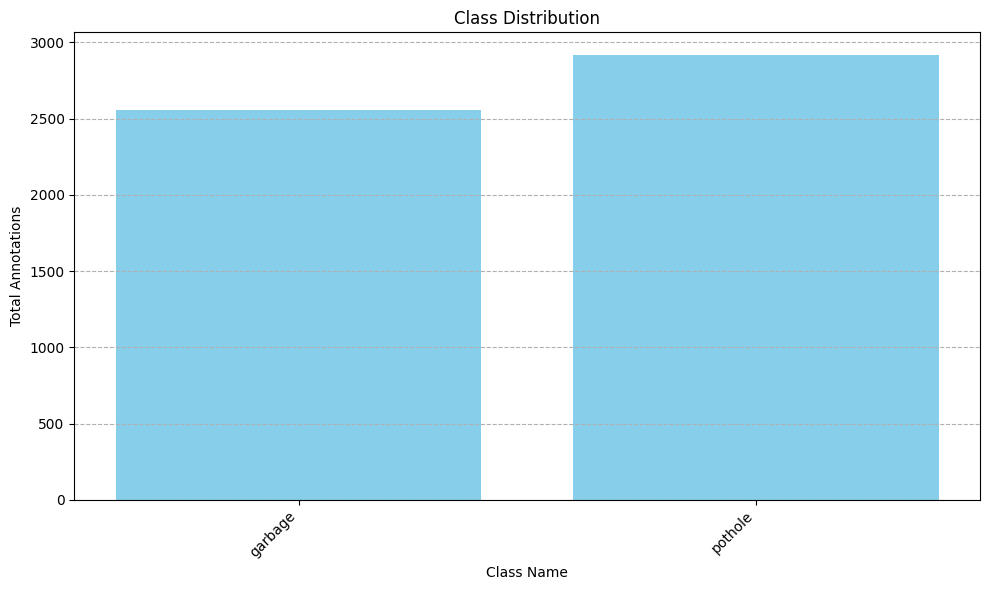

In [ ]:
import os
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path

# --- 1. SETUP PATHS ---
base_dir = Path('data')
train_label_dir = base_dir / 'train' / 'labels'
valid_label_dir = base_dir / 'valid' / 'labels'
yaml_path = base_dir / 'data.yaml'

# --- 2. LOAD CONFIG ---
try:
    with open(yaml_path, 'r') as f:
        config = yaml.safe_load(f)
    print(f"✅ Loaded config from {yaml_path}")
except FileNotFoundError:
    print(f"⚠️ Could not find {yaml_path}. Using dummy names.")
    config = {'names': {0: 'class_0'}}

# --- 3. COUNTING FUNCTION (FIXED) ---
def get_class_counts(label_dir):
    """Counts class IDs in YOLO .txt files, handling '0.0' format."""
    counts = Counter()
    path_obj = Path(label_dir)
    
    if not path_obj.exists():
        print(f"⚠️ Warning: Folder not found: {path_obj}")
        return counts

    files = list(path_obj.glob('*.txt'))
    print(f"   Found {len(files)} label files in {label_dir}")
    
    for file_path in files:
        with open(file_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if parts:
                    try:
                        class_id = int(float(parts[0])) 
                        counts[class_id] += 1
                    except ValueError:
                        continue
    return counts

# --- 4. CALCULATE COUNTS ---
print("Scanning dataset...")
train_counts = get_class_counts(train_label_dir)
valid_counts = get_class_counts(valid_label_dir)

# --- 5. VISUALIZATION ---
all_indices = set(train_counts.keys()) | set(valid_counts.keys())
class_names = config.get('names') 

data = []
for idx in sorted(all_indices):
    # Name resolution
    if isinstance(class_names, list):
        name = class_names[idx] if 0 <= idx < len(class_names) else f'Class {idx}'
    elif isinstance(class_names, dict):
        name = class_names.get(idx, f'Class {idx}')
    else:
        name = f'Class {idx}'

    t_count = train_counts.get(idx, 0)
    v_count = valid_counts.get(idx, 0)
    total_count = t_count + v_count
    data.append([idx, name, t_count, v_count, total_count])

# Create DataFrame
df = pd.DataFrame(data, columns=['Index', 'Class Name', 'Train Count', 'Valid Count', 'Total Count'])

print("\n--- Dataset Class Balance Overview ---")
try:
    print(df.to_markdown(index=False))
except AttributeError:
    print(df)

# Plot
if not df.empty:
    plt.figure(figsize=(10, 6))
    plt.bar(df['Class Name'], df['Total Count'], color='skyblue')
    plt.title('Class Distribution')
    plt.xlabel('Class Name')
    plt.ylabel('Total Annotations')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()
else:
    print("❌ No data to plot.")

In [ ]:
### 4.1. Load the Trained Model
from ultralytics import YOLO

MODEL_PATH = 'yolov8m.pt'
DATA_YAML_PATH = 'data/data.yaml' 

print(f"--- Loading Trained Model from {MODEL_PATH} ---")

try:
    model = YOLO(MODEL_PATH)
    print("✅ Model loaded successfully.")

    ### 4.2. Run Final Validation
    print("\n--- Running Final Validation on the Validation Set ---")
    
    # Run validation
    metrics = model.val(data=DATA_YAML_PATH)

    ### 4.3. Display Performance Metrics
    print("\n--- Industry-Level Performance Metrics ---")

    mAP50 = metrics.box.map50
    mAP50_95 = metrics.box.map
    precision = metrics.box.mp  
    recall = metrics.box.mr     

    print(f"Average Precision (mAP@0.5):      {mAP50:.4f}")
    print(f"Average Precision (mAP@0.5:0.95): {mAP50_95:.4f}")
    print(f"Mean Precision:                   {precision:.4f}")
    print(f"Mean Recall:                      {recall:.4f}")

    print("\n--- Detailed Class Metrics (mAP@0.5:0.95) ---")
    
    class_names = model.names
    class_maps = metrics.box.maps 

    for idx, name in class_names.items():
        if idx < len(class_maps):
            print(f"- {name}: {class_maps[idx]:.4f}")
            
    print("\n--- Validation Complete ---")

except FileNotFoundError:
    print(f"❌ Error: Model file not found at {MODEL_PATH}. Please ensure best.pt is in the root directory.")
except AttributeError as e:
    print(f"❌ Attribute Error: {e}")
    print("Tip: If using an older YOLO version, attributes might differ.")
except Exception as e:
    print(f"❌ An error occurred: {e}")

--- Loading Trained Model from yolov8m.pt ---
✅ Model loaded successfully.

--- Running Final Validation on the Validation Set ---
Ultralytics 8.3.235  Python-3.13.6 torch-2.9.1+cpu CPU (11th Gen Intel Core i5-1135G7 @ 2.40GHz)
Model summary (fused): 92 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access  (ping: 0.10.1 ms, read: 6.92.0 MB/s, size: 73.8 KB)
val: Scanning E:\Fourise\smart-city\data\valid\labels... 562 images, 7 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 562/562 479.3it/s 1.2s0.0s
val: New cache created: E:\Fourise\smart-city\data\valid\labels.cache
WARNING Box and segment counts should be equal, but got len(segments) = 56, len(boxes) = 623. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 36/36 7.7s/it 4:387.8ss
    

In [6]:
# Run inference on a few validation images to see the visual results
results = model.predict(source='data/valid/images', save=True, max_det=5, conf=0.25)
print(f"Predictions saved to: {results[0].save_dir}")


image 1/562 e:\Fourise\smart-city\data\valid\images\-libre-place-des-dejections-en-plusieurs-langues-photo-marc-wirtz-1430300655_jpg.rf.68713b59445ee425b735eaea37ba54cd.jpg: 640x640 1 garbage, 433.1ms
image 2/562 e:\Fourise\smart-city\data\valid\images\-noir-C3A0-cC3B4tC3A9-de-la-clC3B4ture-du-bureau-C3A0-domicile-sur-la-rue-3r_jpg.rf.ce6098d66b1c44201dc4185b9bb5455e.jpg: 640x640 1 garbage, 476.4ms
image 3/562 e:\Fourise\smart-city\data\valid\images\000273202W_jpg.rf.4888eecd6115aebbf2e7e7f2ede0b1a7.jpg: 640x640 1 garbage, 477.4ms
image 4/562 e:\Fourise\smart-city\data\valid\images\004633f2-679f-11e5-b0e3-40f2e96c8ad8_jpg.rf.981d80f2caa60b7709d0abf06ed0ec45.jpg: 640x640 2 garbages, 483.5ms
image 5/562 e:\Fourise\smart-city\data\valid\images\0602669809922-web-tete_jpg.rf.6bc0a96f19e5c204f00a2fc66601b719.jpg: 640x640 2 garbages, 394.6ms
image 6/562 e:\Fourise\smart-city\data\valid\images\0bd7f188-679f-11e5-b0e3-40f2e96c8ad8_jpg.rf.87dc0891eaeab28102529cb75b38e74f.jpg: 640x640 1 garbage,

In [7]:
### 5.1. Select an image for prediction
VALID_IMAGE_DIR = 'data/valid/images'
image_files = [f for f in os.listdir(VALID_IMAGE_DIR) if f.endswith(('.jpg', '.png', '.jpeg'))]

if image_files:
    sample_image = os.path.join(VALID_IMAGE_DIR, image_files[0])
    
    print(f"--- Running Inference on Sample Image: {sample_image} ---")

    ### 5.2. Run Inference and Save Results
    results = model(sample_image, save=True, conf=0.25) # conf=0.25 is a common minimum confidence

    print(f"✅ Prediction complete. Output saved in a folder inside 'runs/detect/predict' (Check your project folder explorer).")

    ### 5.3. Display the result (optional but good for visual verification)
    try:
        
        
        from PIL import Image
        import glob
        
        # Find the latest prediction folder
        runs_dir = 'runs/detect'
        predict_folders = glob.glob(os.path.join(runs_dir, 'predict*'))
        if predict_folders:
            latest_predict_folder = max(predict_folders, key=os.path.getctime)
            saved_image_path = os.path.join(latest_predict_folder, os.path.basename(sample_image))
            
            if os.path.exists(saved_image_path):
                img = Image.open(saved_image_path)
                plt.figure(figsize=(12, 12))
                plt.imshow(img)
                plt.title(f"Visual Verification: Model Prediction on {os.path.basename(sample_image)}")
                plt.axis('off')
                plt.show()
            else:
                print(f"Could not find the saved result image at {saved_image_path}")
        
    except Exception as e:
        print(f"Note: Could not display image in the notebook (requires additional setup or libraries). Check your 'runs/detect/predict' folder manually for the visual output.")

else:
    print(f"No image files found in {VALID_IMAGE_DIR} for visual verification.")

--- Running Inference on Sample Image: data/valid/images\-libre-place-des-dejections-en-plusieurs-langues-photo-marc-wirtz-1430300655_jpg.rf.68713b59445ee425b735eaea37ba54cd.jpg ---

image 1/1 e:\Fourise\smart-city\data\valid\images\-libre-place-des-dejections-en-plusieurs-langues-photo-marc-wirtz-1430300655_jpg.rf.68713b59445ee425b735eaea37ba54cd.jpg: 640x640 1 garbage, 431.1ms
Speed: 19.7ms preprocess, 431.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to E:\Fourise\Smart City Issue Detector\runs\detect\predict5
✅ Prediction complete. Output saved in a folder inside 'runs/detect/predict' (Check your project folder explorer).


--- Testing on image: data\test\images\youtube-2_jpg.rf.4ddbb2cb4b540cb0aac2efa79edbf888.jpg ---

image 1/1 e:\Fourise\smart-city\data\test\images\youtube-2_jpg.rf.4ddbb2cb4b540cb0aac2efa79edbf888.jpg: 640x640 1 pothole, 366.2ms
Speed: 6.8ms preprocess, 366.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


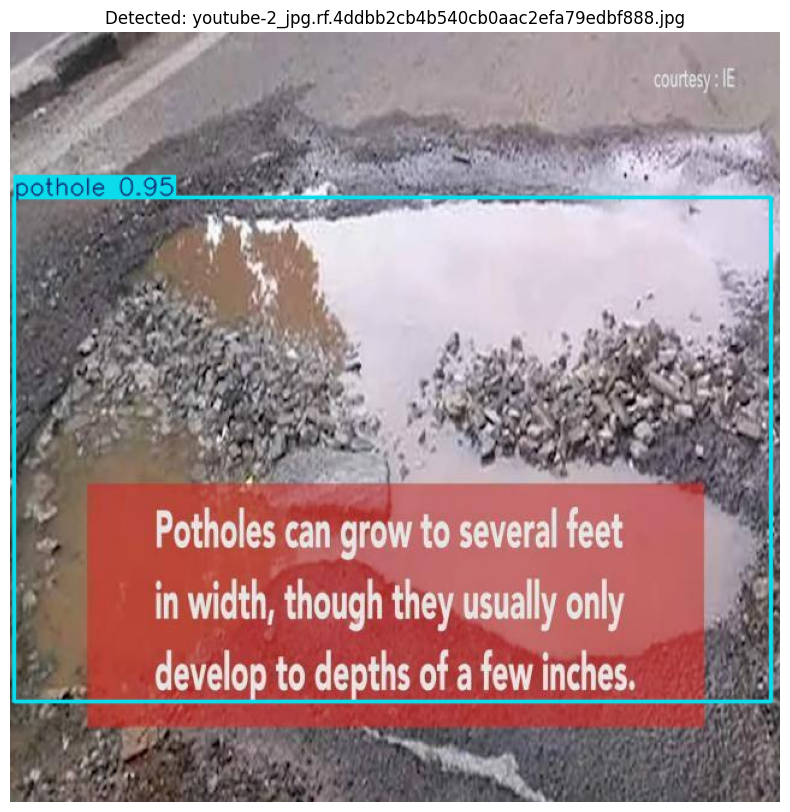

In [ ]:
import os
import random
import glob
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt

# 1. Define where your test images are (Based on your screenshot)
test_images_path = os.path.join('data', 'test', 'images', '*.jpg')
test_files = glob.glob(test_images_path)

# 2. Check if we found images
if len(test_files) > 0:
    selected_file = random.choice(test_files)
    print(f"--- Testing on image: {selected_file} ---")
    
    # 3. Load Model (if not already loaded)
    if 'model' not in locals():
        model = YOLO('best.pt') 

    # 4. Run Prediction
    results = model.predict(selected_file, conf=0.25)

    # 5. Show Result
    for r in results:
        im_array = r.plot()  
        im = Image.fromarray(im_array[..., ::-1])  
        
        plt.figure(figsize=(10, 10))
        plt.imshow(im)
        plt.axis('off')
        plt.title(f"Detected: {os.path.basename(selected_file)}")
        plt.show()

else:
    print(f"❌ No images found in {test_images_path}. Check your folder structure.")

In [15]:
!pip install gradio


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import gradio as gr
from ultralytics import YOLO
from PIL import Image

# 1. Load your trained model
model = YOLO('yolov8m.pt')  

# 2. Define the prediction function
def predict_image(image):
    # Run inference
    results = model(image, conf=0.25)
    
    detection_summary = {}
    total_detections = 0
    plotted_image = None
    
    for r in results:
        # --- 2.1. Count Detections ---
        boxes = r.boxes  
        class_indices = boxes.cls.tolist()
        class_names = model.names 
        
        # Count occurrences of each class
        for cls_index in class_indices:
            name = class_names.get(int(cls_index), 'Unknown')
            detection_summary[name] = detection_summary.get(name, 0) + 1
            total_detections += 1
            
        # --- 2.2. Plot the Image ---
        im_array = r.plot()  # BGR numpy array with drawn boxes
        plotted_image = Image.fromarray(im_array[..., ::-1])  # Convert BGR to RGB PIL Image
        
    # --- 2.3. Create the Description String ---
    if total_detections == 0:
        description = "No major issues (potholes or garbage) were detected in the image."
    else:
        description_parts = [
            f"{count} {name}{'s' if count > 1 else ''}" 
            for name, count in detection_summary.items()
        ]
        
        # Join the parts into a natural sentence 
        if len(description_parts) == 1:
            description = f"{description_parts[0]} detected."
        elif len(description_parts) > 1:
            # Join all but the last with a comma, then add " and "
            description = ", ".join(description_parts[:-1]) + f" and {description_parts[-1]} detected."
        
        description = f"Total of {total_detections} issues detected: {description}"
        
    # --- 2.4. Return the Image and the Description ---
    return plotted_image, description

# 3. Create the Interface
interface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil", label="Upload an Image"),
    # Define two outputs: the image and the text description
    outputs=[
        gr.Image(type="pil", label="Detection Result"),
        gr.Textbox(label="Prediction Summary") 
    ],
    title="Smart City Issue Detector",
    description="Upload a photo of a road to detect and count issues like potholes or garbage."
)

# 4. Launch it
interface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7861

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.



0: 352x640 1 garbage, 1 pothole, 265.6ms
Speed: 77.8ms preprocess, 265.6ms inference, 2.6ms postprocess per image at shape (1, 3, 352, 640)
